In [43]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

1.12.9


# Подготавливаем данные

In [44]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [45]:
df.shape

(383, 7)

In [46]:
df.date = pd.to_datetime(df.date)

In [47]:
plotly_df(df.set_index('date')[['count']])

# Предсказание с помощью Facebook Prophet
Для начала построим предсказание с помощью простой библиотеки Facebook Prophet. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [48]:
from fbprophet import Prophet

In [49]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [50]:
train_df.tail()

,ds,y
358,2015-12-17,2870
363,2015-12-18,2475
364,2015-12-19,1659
344,2015-12-20,1534
343,2015-12-21,2425


 Далее создаем объект класса Prophet (все параметры модели задаются в конструкторе класса, для начала возьмем default'ные параметры) и обучаем его.

In [51]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df)


С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, который содержит все исторические временные точки и еще 30 дней, для которых мы хотели построить прогноз.

Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге dataframe future.

In [52]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

# 1. Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

In [53]:
import datetime
round(forecast[forecast.ds==datetime.date(2016, 1, 20)].yhat,0)#y с крышкой - это прогноз

382    3833.0
Name: yhat, dtype: float64

## 2. MAPE для модели Prophet по последним 30 дням. 
## 3. MAE для модели Prophet по последним 30 дням. 

In [54]:
import numpy as np

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', round(np.mean(abs(cmp_df[-predictions:]['p'])),2))
print ('MAE', round(np.mean(abs(cmp_df[-predictions:]['e']))))

MAPE 38.38
MAE 713


## 4. Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным и какое p-value?

adf:  -2.53411784342
Critical values:  {'1%': -3.4499043309021955, '5%': -2.8701548853389252, '10%': -2.5713597190254385}
Критерий Дики-Фуллера: p= 0.107
есть единичные корни, ряд не стационарен
Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. - Не выполняется.


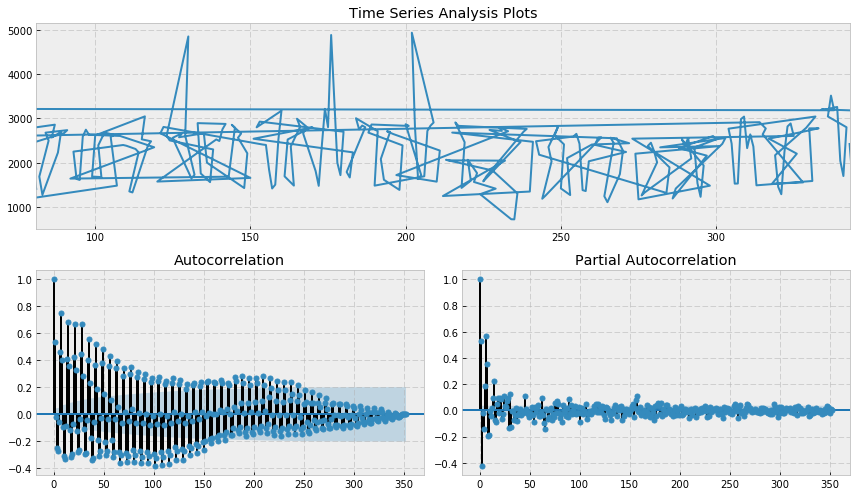

In [55]:
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
%matplotlib inline

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        vals=sm.tsa.stattools.adfuller(y)
        print('adf: ', vals[0])
        print('Critical values: ', vals[4])
        print("Критерий Дики-Фуллера: p=", round(vals[1],3))
        
        if vals[0]> vals[4]['5%']: 
            print ('есть единичные корни, ряд не стационарен')
        else:
            print ('единичных корней нет, ряд стационарен')
        print('Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. - Не выполняется.')
            
        plt.tight_layout()
    return
    

tsplot(train_df.y)

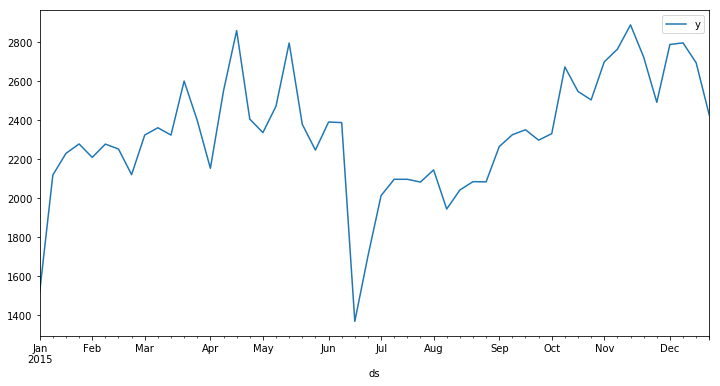

In [56]:
 tval=train_df.set_index('ds')#Делаем новую колонку индексом
 tval.resample('W').mean().plot(figsize=(12,6))
 
 del tval

# Вопрос 5: Далее перейдем к построению модели SARIMAX (sm.tsa.statespace.SARIMAX). Модель c какими параметрами лучшая по AIC-критерию?